## HELOC

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output
from keras.callbacks import Callback, EarlyStopping
from keras.regularizers import l1_l2
from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import initializers
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l1

In [3]:
#read in datset heloc_dataset_v1.csv
data = pd.read_csv('/Users/davidbellenberg/Library/CloudStorage/OneDrive-Personal/university/cbs/courses/ml/final_project/heloc_dataset_v1.csv')

## preproccessing

In [4]:
# Encode the target variable
le = LabelEncoder()
data['RiskPerformance'] = le.fit_transform(data['RiskPerformance'])

# Split the dataset into features (X) and target (y)
X = data.drop('RiskPerformance', axis=1)
y = data['RiskPerformance']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## model architecture

In [17]:
# Define the neural network model
def create_model(learning_rate=0.001, dropout_rate=0.5, num_neurons=128):
    model = Sequential()

    # Input layer
    model.add(Dense(num_neurons, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Hidden layer
    model.add(Dense(num_neurons//2, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

## helper function (live plot)

In [8]:
class LivePlotCallback(Callback):
    def __init__(self, figsize=(10, 5)):
        super(LivePlotCallback, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs=None):
        self.epochs = []
        self.training_accuracies = []
        self.validation_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch)
        self.training_accuracies.append(logs.get('accuracy'))
        self.validation_accuracies.append(logs.get('val_accuracy'))

        # Clear the output before plotting the updated figure
        clear_output(wait=True)

        plt.figure(figsize=self.figsize)
        plt.plot(self.epochs, self.training_accuracies, label='Training Accuracy')
        plt.plot(self.epochs, self.validation_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.legend()
        plt.show()

In [18]:
# Create a model object
model = create_model()
# Print the model summary
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               3072      
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 64)               

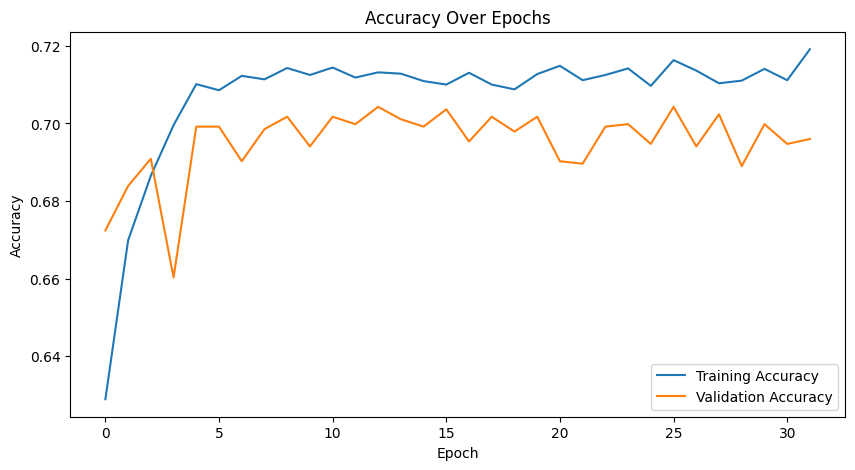

139/139 [==============================] - 0s 2ms/step - loss: 0.6380 - accuracy: 0.7191 - val_loss: 0.6544 - val_accuracy: 0.6960


In [15]:
# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the optimized model
live_plot = LivePlotCallback()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[early_stopping, live_plot])

## grid search

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define a custom function to generate a model with the specified parameters
def generate_model(learning_rate=0.001, dropout_rate=0.5, num_neurons=128):
    return KerasClassifier(
        create_model,
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        num_neurons=num_neurons
    )

# Define the grid search parameters
param_grid = {
    'epochs': [10, 20, 30],
    'batch_size': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.4, 0.5, 0.6],
    'num_neurons': [64, 128, 256]
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=generate_model(), param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search to the data
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and corresponding score
print(f"Best score: {grid_result.best_score_:.4f} using {grid_result.best_params_}")


# create plot

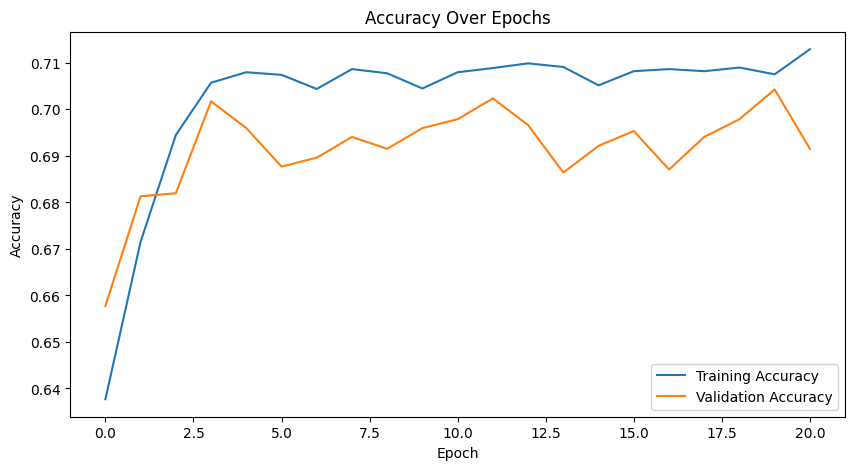

In [6]:
# Plot the accuracy over the epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

## Save history as csv file

In [ ]:
#whole histoty as csv
hist_df = pd.DataFrame(history.history)
# round dataframe to 3 decimal places
hist_df = hist_df.round(3)
# save to csv
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)